In [1]:
"""
Define markowitz portfolio optimization
Construct the QP 
Prepare an initial state
Define a driver hamiltonian
Initialize the QAOA ansatz
Define cost function
Define Optimizer
Optimize
Post Process
"""

'\nDefine markowitz portfolio optimization\nConstruct the QP \nPrepare an initial state\nDefine a driver hamiltonian\nInitialize the QAOA ansatz\nDefine cost function\nDefine Optimizer\nOptimize\nPost Process\n'

# Create Portfolio Class

In [2]:
import numpy as np
from qiskit_optimization import QuadraticProgram
from qiskit import QuantumCircuit
import itertools
from qiskit.quantum_info import SparsePauliOp
from itertools import product


class Portfolio:
    def __init__(self, sigma, mu, q, B):
        """
        sigma: covariance matrix (numpy 2D array)
        mu: expected returns (numpy array)
        q: risk aversion parameter (float)
        """

        self.sigma = sigma
        self.mu = mu
        self.q = q
        self.B = B
        # This is the variable for the number of qubits and nodes in the problem
        self.n = len(mu)

    def construct_qp(self):
        # I most likely need to go in and add the constraints to this function. Due to limitations of state initialization, it is difficult only initialize valid solution states without it bleeding into the wrong
        # states as well.
        sigma = self.sigma
        mu = self.mu
        q = self.q
        n = self.n

        # We use quadratic program from qiskit_optimization to build a qp. Using qiskit's QP class will easily let us convert this to an ising problem
        # When building the qp, we do not include constraints because the goal is to include those in the mixer hamiltonian
        qp = QuadraticProgram() 

        #For the quadratic program, we need a binary variable for each node in the graph. Each binary variable represents whether each node is included in the solution
        for i in range(n):
            qp.binary_var(str(i))

        # This adds the quadratic term to the quadrratic program. Check out Markowitz portfolio optimization for more info
        qp.objective.quadratic = q * sigma

        # This adds the linear term to the quadratic
        qp.objective.linear = -mu

        qp.linear_constraint(
        linear={str(i): 1 for i in range(self.n)},  # Coefficients: 1*x_0 + 1*x_1 + ... + 1*x_{n-1}
        sense='==',                                 # Equality constraint
        rhs=self.B,                                 # Right-hand side = B
        name='hamming_weight_constraint'
)

        return qp
    
    def build_initial_state(self):
        """Return a circuit that initializes a Dicke state of Hamming weight k over n qubits"""
        # Create a statevector with 1s at positions with Hamming weight k
        k = self.B
        n = len(self.mu)
        state = np.zeros(2**n)
        for bits in itertools.combinations(range(n), k):
            index = sum([1 << (n - 1 - b) for b in bits])  # convert bit positions to integer
            state[index] = 1

        state = state / np.linalg.norm(state)  # normalize

        # Create circuit and initialize state
        qc = QuantumCircuit(n)
        qc.initialize(state, range(n))
        return qc
    
    # Apologies for switiching between driver and mixer. The words are interchangable. Ill try to stick with mixer because Qiskit uses mixer
    def build_XY_mixer(self):
        paulis_for_mixer = [] # We need a list of paulis and coefficients for the operator 
        list_of_paulis = ['X', 'Y'] # We need to repeat the following loop for each pauli in our hamiltonian, so we create this list to do it more easily.

        #The driver hamiltonian is summation (X_i * X_j + Y_i*Y_j) for all i < j

        for pauli in list_of_paulis:
            for i in range(self.n):
                temp = None # I probably dont need this, but I dont want to accidentally point to something else when I go use the variable in the next loop.

                for j in range (i+1, self.n):
                    temp = ['I'] * self.n # Puts an identity gate on each qubit
                    temp[i] = pauli # Per the hamiltonian, we put either an X or Y pauli gate on the ith qubit

                    temp[j] = pauli # Per the hamiltonian, we put either an X or Y pauli gate on the jth qubit
                    temp = "".join(temp) # This turns the temp char array into a string
                    paulis_for_mixer.append(temp) # Combines the strings into an array of strings. Each string represents one level of paulis on the entire circuit.

        coefficients = [1.0 for i in range(len(paulis_for_mixer))] # Coefficients for each operator. They are all one. 

        mixer_list = list(zip(paulis_for_mixer, coefficients)) # Creates a list of tuples combinining the pauli strings and the coefficients
        mixer_hamiltonian = SparsePauliOp.from_list(mixer_list) #Createas the pauli operator that can later be passed to QAOAAnsatz's mixer_operator constructor
                
        return mixer_hamiltonian
    
# This function calculates the cost of a specific solution 
def markowitz_cost(x, sigma, mu, q):
    """
    x: Binary decision variable (numpy array)
    sigma: covariance matrix (numpy 2D array)
    mu: expected returns (numpy array)
    q: risk aversion parameter (float)
    
    """
    x = np.array(x)
    quadratic_term = q * x.T @ sigma @ x
    linear_term = mu.T @ x
    return quadratic_term - linear_term

def brute_force_markowitz(sigma, mu, q, B):
    n = len(mu)
    best_cost = float('inf')
    best_x = None

    for x in product([0, 1], repeat=n):
        if sum(x) != B:
            continue
        cost = markowitz_cost(x, sigma, mu, q)
        if cost < best_cost:
            best_cost = cost
            best_x = x
    return best_x, best_cost



# Construct Quadratic Program 

In [3]:
from Define_Portfolio import generate_portfolio
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_finance.applications.optimization import PortfolioOptimization

# The four lines below contain information that would typically be provided by the client. I randomly generate to test the concept.

n = 10 # Variable that determines the problem size. This is the number of potential investment items.
mu, sigma = generate_portfolio(n, isRandom= False) # This creates a random portfolio relation to easily test what I am doing
q = 0.5 # Risk aversion term. This is how much risk the customer is willing to accept
B = 2 # Constraint of how many items the customer can include in the portfolio
reps = 1 # Number of reps of the ansatz
shots = 10000 # Number of shots on the sampler


#I create a portfolio class instance with the client information above. Portfolio is a custom class I made. 
# IT IS NOT THE SAME PORTFOLIO CLASS FROM QISKIT-FINANCE
customer = Portfolio(sigma, mu, q, B)

qp = customer.construct_qp() # Turn the portfolio to a quadratic program as explained in a previous cell

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
cost_hamiltonian = qubo.to_ising()[0] # Converts the qp to an ising hamiltonian. This hamiltonian is directly loaded into QAOAAnsatz

print(qubo.prettyprint())
print(cost_hamiltonian)




Problem name: 

Minimize
  85.09842748730911*0^2 + 170.57139509346558*0*1 + 171.14756928102815*0*2
  + 170.92884891642962*0*3 + 170.79551345881526*0*4 + 170.35287361506067*0*5
  + 170.35284949495443*0*6 + 170.2549385867864*0*7 + 171.06303112039313*0*8
  + 170.7979699863614*0*9 + 85.09842748730911*1^2 + 170.90492755241428*1*2
  + 170.21743946891402*1*3 + 171.1667648267802*1*4 + 171.02929761541864*1*5
  + 170.4091940852965*1*6 + 170.37867994182534*1*7 + 170.38025948447165*1*8
  + 170.50109721757775*1*9 + 85.09842748730911*2^2 + 170.72161140625047*2*3
  + 170.62879999326032*2*4 + 170.48808411481627*2*5 + 170.8087078693406*2*6
  + 170.33634883527026*2*7 + 170.48899962315343*2*8 + 170.5632168179119*2*9
  + 85.09842748730911*3^2 + 170.65292495883526*3*4 + 170.98203093601123*3*5
  + 170.39652875677658*3*6 + 170.71108941303183*3*7 + 170.78926954348026*3*8
  + 170.2433053873382*3*9 + 85.09842748730911*4^2 + 170.80439982651967*4*5
  + 170.3673790983055*4*6 + 170.2619065676035*4*7 + 171.145740511

# Prepare Initial State

In [4]:
initial_state = customer.build_initial_state()
# initial_state.draw()

# Prepare Driver

In [5]:
mixer_operator = customer.build_XY_mixer() # Creates the sparse pauli op driver hamiltonian that swaps the bits
print(len(mixer_operator))
print(mixer_operator)


90
SparsePauliOp(['XXIIIIIIII', 'XIXIIIIIII', 'XIIXIIIIII', 'XIIIXIIIII', 'XIIIIXIIII', 'XIIIIIXIII', 'XIIIIIIXII', 'XIIIIIIIXI', 'XIIIIIIIIX', 'IXXIIIIIII', 'IXIXIIIIII', 'IXIIXIIIII', 'IXIIIXIIII', 'IXIIIIXIII', 'IXIIIIIXII', 'IXIIIIIIXI', 'IXIIIIIIIX', 'IIXXIIIIII', 'IIXIXIIIII', 'IIXIIXIIII', 'IIXIIIXIII', 'IIXIIIIXII', 'IIXIIIIIXI', 'IIXIIIIIIX', 'IIIXXIIIII', 'IIIXIXIIII', 'IIIXIIXIII', 'IIIXIIIXII', 'IIIXIIIIXI', 'IIIXIIIIIX', 'IIIIXXIIII', 'IIIIXIXIII', 'IIIIXIIXII', 'IIIIXIIIXI', 'IIIIXIIIIX', 'IIIIIXXIII', 'IIIIIXIXII', 'IIIIIXIIXI', 'IIIIIXIIIX', 'IIIIIIXXII', 'IIIIIIXIXI', 'IIIIIIXIIX', 'IIIIIIIXXI', 'IIIIIIIXIX', 'IIIIIIIIXX', 'YYIIIIIIII', 'YIYIIIIIII', 'YIIYIIIIII', 'YIIIYIIIII', 'YIIIIYIIII', 'YIIIIIYIII', 'YIIIIIIYII', 'YIIIIIIIYI', 'YIIIIIIIIY', 'IYYIIIIIII', 'IYIYIIIIII', 'IYIIYIIIII', 'IYIIIYIIII', 'IYIIIIYIII', 'IYIIIIIYII', 'IYIIIIIIYI', 'IYIIIIIIIY', 'IIYYIIIIII', 'IIYIYIIIII', 'IIYIIYIIII', 'IIYIIIYIII', 'IIYIIIIYII', 'IIYIIIIIYI', 'IIYIIIIIIY', 'IIIYYIIIII', 'I

In [6]:
# ### Temp Playground Cell ###
# from qiskit.quantum_info import Statevector

# sv = Statevector(initial_state)
# sv.draw("latex")


In [7]:
# ### Temp Playground Cell ###

# sv = sv.evolve(mixer_operator)
# sv.draw("latex")


# Initialize QAOA ansatz

In [8]:
from qiskit.circuit.library import QAOAAnsatz
ansatz = QAOAAnsatz(cost_operator=cost_hamiltonian, mixer_operator= mixer_operator,initial_state=initial_state, reps = reps).decompose(reps = 5)
init_params = [np.pi / 2 for i in range(2 * reps)]
# ansatz.draw(fold = - 1) # This will kill the kernel for large circuits. I dont reccomend going over n = 12
ansatz.depth()

2215

# Initialize Cost Function

In [9]:
#Global variable
costs = []

def cost_func(params, ansatz, hamiltonian, estimator):
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)

    job = estimator.run(pubs = [pub]).result()[0]

    cost = job.data.evs
    print(cost)
    costs.append(cost)
    return cost


# Initialize Estimator

In [10]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
backend = AerSimulator()

estimator = Estimator(mode = backend)
print(backend.description)
# pm = generate_preset_pass_manager(optimization_level = 1, backend = backend)
# ansatz_isa = pm.run(ansatz)

A C++ Qasm simulator with noise


# Define Optimizer

In [11]:
from scipy.optimize import minimize

optimizer_results = minimize(
    fun = cost_func,
    x0 = init_params,
    args=(ansatz, cost_hamiltonian, estimator),
    method = "COBYLA",
    tol=1e-4
)

print(optimizer_results)

-964.0149710845819
-303.4894946167514
-963.9733226508325
-322.65955508615826
-25.14288724147569
-72.0899502293648
-964.0305437736818
-205.29767702912318
-848.5511297128478
-953.256325692185
-963.4679295793453
-964.0289508872534
-963.0524734707965
-963.4810189424015
-964.1361735367653
-964.1281375715078
-964.17466948214
-964.1983586997786
-964.1166154094102
-964.242826678879
-964.1547519151273
-964.2244115614369
-964.2646400148286
-964.1911712099169
-964.1832139505415
-964.1305367294522
-964.3405380081076
-964.3305086250284
-964.2530187192145
-964.2613140540043
-964.2900508635569
-964.2935436594358
-964.2696230847262
-964.2155350133934
-964.2468170076032
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -964.2468170076032
       x: [ 1.589e+00  1.449e+00]
    nfev: 35
   maxcv: 0.0


# Begin Post Processing
### With the optimal parameters, we need to get the associated bitstring

In [12]:
from qiskit_ibm_runtime import Sampler
from Define_PostProcessing import process_sampler_results

optimized_circuit = ansatz.assign_parameters(optimizer_results.x)
optimized_circuit.measure_all()
sampler = Sampler(mode = backend)

pub= (optimized_circuit)
job = sampler.run([pub], shots=shots)
original_count_dict = job.result()[0].data.meas.get_counts()

print("Length of Original Count Dictionary:", len(original_count_dict))
print(original_count_dict)

filtered_counts = process_sampler_results(job, B)
print("Length of filtered counts dictionary:",len(filtered_counts))
print(filtered_counts)

Length of Original Count Dictionary: 47
{'0100001000': 281, '0110000000': 283, '0010100000': 262, '0000101000': 292, '0001100000': 226, '0010000100': 272, '0010000010': 218, '1000001000': 155, '0000100001': 140, '0010010000': 182, '1000000001': 155, '0000001100': 241, '0100100000': 251, '0000100010': 198, '0000000110': 206, '0000100100': 272, '0000010100': 223, '0101000000': 321, '0000001001': 182, '0001001000': 207, '1010000000': 279, '0000010001': 138, '0001000100': 241, '0011000000': 240, '0001000001': 234, '0000011000': 185, '1001000000': 183, '0000000011': 189, '0000110000': 207, '1100000000': 196, '0000010010': 152, '0001000010': 279, '0100010000': 230, '0000000101': 215, '1000000100': 197, '1000000010': 199, '0100000001': 219, '0001010000': 214, '0100000010': 295, '0010000001': 160, '0100000100': 312, '0000001010': 216, '1000100000': 222, '0010001000': 248, '1000010000': 181, '0101010001': 1, '0000000000': 1}
Length of filtered counts dictionary: 45
[(321, '0000001010'), (312, '

In [13]:

binary_decision_variables = []
for item in filtered_counts:
    binary_decision_variables.append([int(bit) for bit in item[1]]) 

states_cost_dict = {}
for array in binary_decision_variables:
    c = markowitz_cost(array, sigma, mu, q)
    states_cost_dict[tuple(array)] = c
    print(f"The cost for {array} is {c}")

print(len(states_cost_dict))

The cost for [0, 0, 0, 0, 0, 0, 1, 0, 1, 0] is -16.577563503042853
The cost for [0, 0, 1, 0, 0, 0, 0, 0, 1, 0] is -13.856809067519377
The cost for [0, 1, 0, 0, 0, 0, 0, 0, 1, 0] is -11.881979755317163
The cost for [0, 0, 0, 1, 0, 1, 0, 0, 0, 0] is -14.37777310968537
The cost for [0, 0, 0, 0, 0, 0, 0, 1, 1, 0] is -18.308874398803162
The cost for [0, 0, 0, 1, 0, 0, 0, 0, 1, 0] is -13.822961728847242
The cost for [0, 1, 0, 0, 0, 0, 1, 0, 0, 0] is -10.656099883826979
The cost for [0, 0, 0, 0, 0, 0, 0, 1, 0, 1] is -14.46466880167396
The cost for [0, 0, 1, 0, 0, 1, 0, 0, 0, 0] is -14.605297349225653
The cost for [0, 0, 1, 0, 0, 0, 0, 1, 0, 0] is -14.456175766767958
The cost for [0, 0, 0, 0, 0, 1, 0, 1, 0, 0] is -18.786221924114106
The cost for [0, 0, 0, 0, 0, 1, 0, 0, 1, 0] is -18.54644766791569
The cost for [0, 0, 0, 1, 0, 0, 0, 1, 0, 0] is -14.347857770661077
The cost for [0, 0, 1, 1, 0, 0, 0, 0, 0, 0] is -10.143026573578666
The cost for [0, 0, 1, 0, 0, 0, 1, 0, 0, 0] is -12.34015555066687

# Solve classically with Brute Force

In [14]:
# Find the key (bitstring) with the lowest cost
min_key = min(states_cost_dict, key=states_cost_dict.get)
print(min_key)
min_cost = states_cost_dict[min_key]

# Print result
print("Quantum Solution ")
print(f"Minimum cost: {min_cost}")
print(f"Bitstring: {list(min_key)}")  # Convert back to list if needed

eigenvector, eigenvalue = brute_force_markowitz(sigma, mu, q, B)
print("_________________________________________________________________________________________")
print("Classical Solution: ")
print(f"Solution State: {list(eigenvector)}")
print(f"Solution Cost: {eigenvalue}")

classical_solution_as_string = ''.join(str(bit) for bit in eigenvector)
print(classical_solution_as_string)

(0, 0, 0, 0, 0, 1, 0, 1, 0, 0)
Quantum Solution 
Minimum cost: -18.786221924114106
Bitstring: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
_________________________________________________________________________________________
Classical Solution: 
Solution State: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
Solution Cost: -18.786221924114106
0000010100


[(321, '0000001010'), (312, '0010000010'), (295, '0100000010'), (292, '0001010000'), (283, '0000000110'), (281, '0001000010'), (279, '0100001000'), (279, '0000000101'), (272, '0010010000'), (272, '0010000100'), (262, '0000010100'), (251, '0000010010'), (248, '0001000100'), (241, '0011000000'), (241, '0010001000'), (240, '0000001100'), (234, '1000001000'), (230, '0000100010'), (226, '0000011000'), (223, '0010100000'), (222, '0000010001'), (219, '1000000010'), (218, '0100000100'), (216, '0101000000'), (215, '1010000000'), (214, '0000101000'), (207, '0001001000'), (207, '0000110000'), (206, '0110000000'), (199, '0100000001'), (198, '0100010000'), (197, '0010000001'), (196, '0000000011'), (189, '1100000000'), (185, '0001100000'), (183, '0000001001'), (182, '1001000000'), (182, '0000100100'), (181, '0000100001'), (160, '1000000100'), (155, '1000000001'), (155, '0001000001'), (152, '0100100000'), (140, '1000010000'), (138, '1000100000')]
0000000011
0000000101
0000000110
0000001001
0000001010

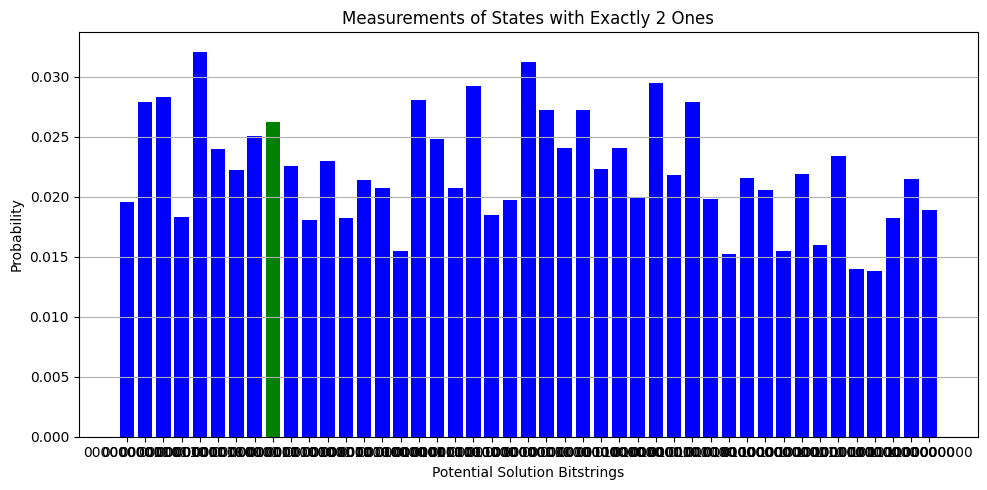

In [15]:
import matplotlib.pyplot as plt

def draw_results(counts_list, B, shots, classical_solution = None):
    # counts_list is [(count, bitstring), ...]
    print(counts_list)
    counts_list = sorted(counts_list, key=lambda x: x[1])  # Optional: sort by bitstring for nicer plots

    # Separate into two lists for plotting
    counts = [count / shots for count, bitstring in counts_list]
    bitstrings = [bitstring for count, bitstring in counts_list]
    colors = ['green' if bitstring == classical_solution else 'blue' for bitstring in bitstrings]
    for bit in bitstrings:
        print(bit)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.bar(bitstrings, counts, color=colors)
    plt.xlabel('Potential Solution Bitstrings')
    plt.ylabel('Probability')
    plt.title(f'Measurements of States with Exactly {B} Ones')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
draw_results(filtered_counts, B, shots, classical_solution = classical_solution_as_string)

In [16]:
from qiskit.quantum_info import Statevector

sv1 = Statevector.from_label('011')
print("011", sv1.expectation_value(cost_hamiltonian))

sv2 = Statevector.from_label('110')
print(sv2.expectation_value(cost_hamiltonian))

011 (-961.003242673328+0j)
(-959.245167582618+0j)
